In [130]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from MiningMinima import *

# Developing subroutine to extract function derivative evaluations

In [131]:
%ls

MiningMinima.py*          find_minimum.py*   mode_scan.pyc*
MiningMinima.pyc*         ga_uc_turner.pdb*  new_min_and_hess_devel.ipynb*
ROSETTA_CRASH.log*        gg_ac.pdb*         new_rigid_body.py*
S_0.pdb*                  gga_gac.pdb*       pose_setup.py*
S_1.pdb*                  hessian.py*        pose_setup.pyc*
Untitled1.ipynb*          hessian.pyc*       rb_mm_movers.py*
Untitled2.ipynb*          hist_list.txt*     rigid_body.py*
calc_hessian_at_min.py*   mm.py*             util.py*
calc_hessian_at_min.pyc*  mode_scan.py*


In [610]:
# use mm object to get stuff 
seq1, seq2 = 'gga', 'ucc'
mm_sim = MiningMinima(seq1,seq2, scorefxn='stepwise/rna/turner_new')

True
True


In [611]:
print mm_sim.hessian

[[  2.74429557e+00   3.35623424e+00   2.72076549e+00  -7.08980384e+00
    1.24105051e+00  -7.69471169e+00   3.98974946e+00  -6.50119111e+00
    2.61301081e+00   1.67994609e-01   4.72311742e+00   2.34475550e-01
   -4.61508691e+00  -3.63109659e-02   1.30625937e+00  -1.04520363e+01
    4.12814104e+00  -1.11098094e+01   5.53821695e+00  -1.02523803e+01
   -1.87896686e-01   8.77357405e-01   7.45455338e+00  -3.35887379e+00
    4.76967156e+00  -4.75340851e+00]
 [  3.35623424e+00   6.56974834e+00   5.46080093e+00  -1.42502234e+01
    5.94520551e+00  -1.52865807e+01   9.72838461e+00  -1.30710673e+01
    3.91776285e+00   3.30774068e+00   1.06257840e+01  -1.24935622e-01
   -5.64700546e+00  -3.03863777e-01   3.09362119e+00  -2.19968694e+01
    1.06708662e+01  -2.12302073e+01   1.49399678e+01  -2.10700368e+01
    1.30510721e+00   4.27991676e+00   1.85760780e+01  -2.13707485e+00
    8.41328727e+00  -5.41289700e+00]
 [  2.72076549e+00   5.46080093e+00   9.96330019e+00  -1.25298128e+01
    1.51000288e+

In [612]:
# get pose and scorefxn 
pose = protocols.recces.pose_setup_turner(seq1=seq1,seq2=seq2)
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner_new')

# set up movemap -- for now just get from the MM object -- and min map
movemap = MoveMap()
movemap.assign(mm_sim.movemap)  
min_map = core.optimization.MinimizerMap()
min_map.setup(pose,movemap)

# set up min options
min_options = core.optimization.MinimizerOptions(
    'lbfgs_armijo_nonmonotone',1e-15,True,False,False)
min_options.nblist_auto_update(True)
# get scorefunction ready for minimization
start_score = scorefxn(pose)
pose.energies().set_use_nblist(pose,min_map.domain_map(),True)
multifunc = core.optimization.AtomTreeMultifunc(pose,min_map,scorefxn)
scorefxn.setup_for_minimizing(pose,min_map) # this is the key command
scorefxn.setup_for_derivatives(pose)

min_dofs = Vector1([0.0]*min_map.nangles())
min_map.copy_dofs_from_pose(pose,min_dofs)
start_func_val = multifunc(min_dofs)
theta = Vector1(list(min_dofs))
dE_dtheta = Vector1(list(min_dofs))
multifunc.dfunc(theta,dE_dtheta)

# set up minimizer and run
minimizer = core.optimization.Minimizer(multifunc,min_options)
for _ in range(1): minimizer.run(min_dofs)
print dE_dtheta

vector1_double[0.204236, 0.818335, 1.82066, -1.05552, 5.38445, -1.89297, 1.37709, -0.579835, -3.73109, 4.83277, 2.35129, 0.0289665, 2.56135, 0.0817805, 1.30417, -5.63551, 11.4594, -5.25188, 6.94324, -4.80557, -5.98501, 10.7529, 8.76755, 9.14961, 7.52379, 2.10211]


In [613]:
multifunc.dfunc(min_dofs, dE_dtheta)

In [614]:
multifunc(min_dofs)

-65.11110761724218

# Developing subroutine to calculate hessian from derivative evaluations

In [615]:
def hessian_at_min(min_dofs,multifunc,h=1e-3):
    min_dofs = np.array(min_dofs) # take advantage of numpy array indexing
    n_dofs = len(min_dofs)
    hessian = np.zeros((n_dofs,n_dofs))
    plus = Vector1([0.0]*n_dofs)
    minus = Vector1(list(plus))
    
    for ii in range(n_dofs):
        new_dofs = min_dofs[:]
        new_dofs[ii] += h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)),plus)
        new_dofs[ii] -= 2.*h*180/np.pi
        multifunc.dfunc(Vector1(list(new_dofs)),minus)
        row = (np.array(plus) - np.array(minus))/2./h
        hessian[ii] = row*(180./np.pi) # need to figure out conversion
    
    return 0.5*(hessian + hessian.T) # enforce symmetry

In [616]:
for _ in range(10):
    minimizer.run(min_dofs)
    print multifunc(min_dofs)

-65.1111411264
-65.1112824846
-65.1112824846
-65.1112824846
-65.1112824846
-65.1112824846
-65.1112824846
-65.1112824846
-65.1112824846
-65.1112824846


In [617]:
hessian = hessian_at_min(min_dofs,multifunc)

In [618]:
print hessian

[[  1.85759149e+02   2.10741577e+02   1.48412444e+02  -4.43052842e+02
    1.75535980e+01  -4.71061430e+02   2.18602933e+02  -3.92069396e+02
    1.63777183e+02  -8.74761375e+01   2.60104526e+02   9.03341149e+00
   -3.44585727e+02  -2.16667710e+00   7.23931978e+01  -6.09045052e+02
    2.05068950e+02  -6.23430480e+02   2.93494607e+02  -6.02716260e+02
   -1.41425396e+01  -8.31127793e+01   4.12234877e+02  -3.35360075e+02
    2.75365227e+02  -3.08612740e+02]
 [  2.10741577e+02   5.04477015e+02   3.35011621e+02  -9.64500443e+02
    2.85010830e+02  -1.01572315e+03   5.89446567e+02  -8.63298436e+02
    2.46883411e+02  -1.40901058e+01   6.29922480e+02  -2.62652589e+00
   -5.53749663e+02  -3.56402769e+01   2.18643557e+02  -1.44155369e+03
    6.70858921e+02  -1.35860137e+03   9.32543730e+02  -1.38811704e+03
    7.40769658e+01   2.54870703e+01   1.18359281e+03  -4.39284234e+02
    5.42107305e+02  -4.38759275e+02]
 [  1.48412444e+02   3.35011621e+02   6.11225665e+02  -7.97327335e+02
    9.00116800e+

In [619]:
from scipy.linalg import eigh

In [620]:
[eigenvalues, modes] = eigh(hessian)

In [621]:
print eigenvalues

[  6.35182059e+00   8.03890097e+00   8.47742895e+00   1.08523863e+01
   1.32310012e+01   1.33977906e+01   1.95032640e+01   2.27864478e+01
   3.24691764e+01   4.82483595e+01   6.01949872e+01   6.39001009e+01
   9.09355022e+01   1.03856733e+02   1.12622215e+02   2.22182709e+02
   3.85724018e+02   5.05038500e+02   5.93423381e+02   1.52463060e+03
   1.59464458e+03   1.88265756e+03   3.62779654e+03   9.10445328e+03
   1.45801775e+04   4.16590035e+04]


In [622]:
for do in min_map.dof_nodes():
    print min_map.torsion_scale_factor(do)

57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131


In [623]:
pseudo_det = 1.
for eigen in eigenvalues:
    if eigen > 0:
        pseudo_det *= eigen
    

In [624]:
print eigenvalues

[  6.35182059e+00   8.03890097e+00   8.47742895e+00   1.08523863e+01
   1.32310012e+01   1.33977906e+01   1.95032640e+01   2.27864478e+01
   3.24691764e+01   4.82483595e+01   6.01949872e+01   6.39001009e+01
   9.09355022e+01   1.03856733e+02   1.12622215e+02   2.22182709e+02
   3.85724018e+02   5.05038500e+02   5.93423381e+02   1.52463060e+03
   1.59464458e+03   1.88265756e+03   3.62779654e+03   9.10445328e+03
   1.45801775e+04   4.16590035e+04]


In [645]:
print multifunc(min_dofs) + 0.5*np.log(pseudo_det) - 0.5*min_map.nangles()*np.log(2*np.pi)

-22.5191342982


# Developing subroutine to mode scan using AtomTreeMultifunc

In [626]:
pmm = PyMOLMover()
pmm.keep_history(True)

In [627]:
from scipy.special import erf

In [628]:
def mode_scan(min_dofs, multifunc, mode, limit=np.pi/3, dx=0.005):
    # convert to np array for useful indexing
    min_dofs = np.array(min_dofs)
    delta_array = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    # intialize result
    result = np.zeros_like(delta_array)
    
    # evaluate using multifunc 
    for ii, delta in enumerate(delta_array):
        new_dofs = min_dofs[:] + delta*mode*180/np.pi
        result[ii] = multifunc(Vector1(list(new_dofs)))
    
    return result    
    
    

In [629]:
def compute_total_partition(min_dofs, multifunc, modes, limit=np.pi/3, dx=0.005):
    # initialize output
    total_log_partition = 0 
    total_log_harmonic = 0
    scans = tuple()
    xx = np.linspace(-limit, limit, int(2*limit/dx)+1)
    
    for ii, mode in enumerate(modes.T): # columns of array are eigenvectors
        if eigenvalues[ii] < 0: continue
        result = mode_scan(min_dofs, multifunc, mode, limit=limit, dx=dx)
        result -= multifunc(min_dofs)
        scans = scans + (result,)
        total_log_partition += np.log(np.trapz(np.exp(-result),dx=dx))
        #total_log_harmonic += np.log(np.trapz(np.exp(-eigenvalues[ii]*xx**2),dx=dx))
        total_log_harmonic += np.log( np.sqrt(2*np.pi/eigenvalues[ii])*(erf(2*limit/np.sqrt(2/eigenvalues[ii]))))
    scans = np.row_stack(scans)
    return total_log_partition, total_log_harmonic, scans

In [630]:
total_log_partition, total_log_harmonic, mode_scans = compute_total_partition(min_dofs, multifunc, modes)

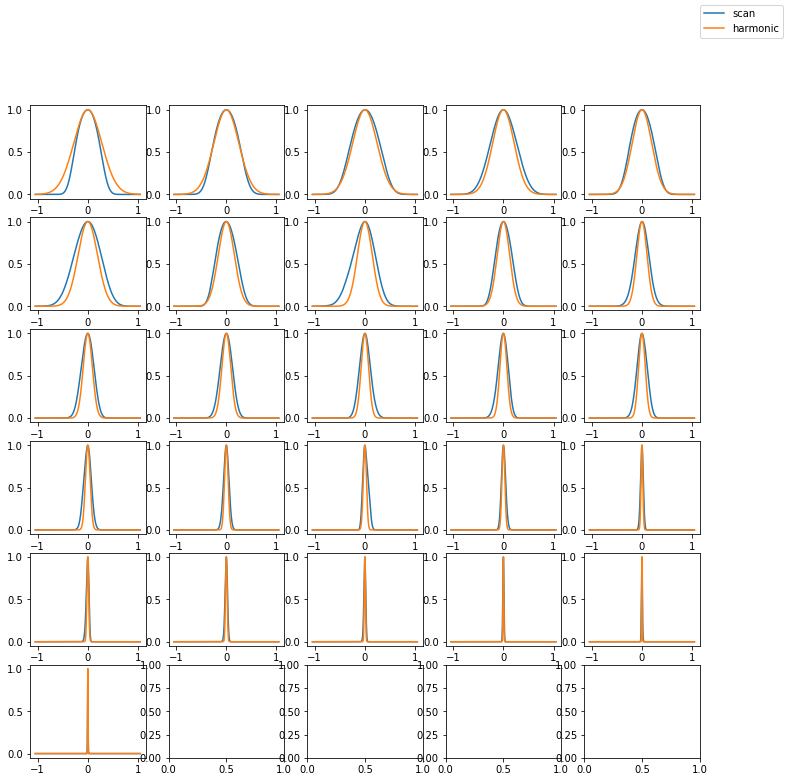

In [631]:
xx = np.linspace(-np.pi/3,np.pi/3,int(2*np.pi/3/0.005)+1)
fig, ax = plt.subplots(ncols=5,nrows=6,figsize=(12,12))
for ii, scan in enumerate(mode_scans):
    if eigenvalues[ii] < 0: continue
    curr_ax = ax.flatten()[ii]
    curr_ax.plot(xx,np.exp(-scan))
    curr_ax.plot(xx,np.exp(-eigenvalues[ii]*xx**2))
fig.legend(('scan', 'harmonic'))

In [632]:
from numpy.linalg import det
from numpy import heaviside
from scipy.special import logsumexp
from scipy.special import gamma

In [633]:
n = min_map.nangles()
min_E = multifunc(min_dofs)
dos = lambda E: (2.0*np.pi)**(n/2.)*(E-min_E)**(n/2. - 1)/gamma(n/2.)/np.sqrt(pseudo_det)*heaviside(E-min_E,0.5)

In [646]:
E = np.linspace(-100, 800, 90001)
F = np.linspace(-100,800,9001)
print -logsumexp(-(E), b=dos(E)*0.01) 
print -logsumexp(-F,b=dos(F)*0.1)


-22.5191342982
-22.5191342982


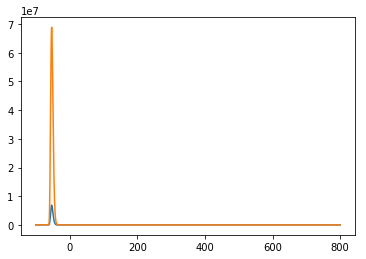

In [635]:
plt.plot(E, dos(E)*np.exp(-E)*0.01)
plt.plot(F, dos(F)*np.exp(-F)*0.1)


In [636]:
print n

26


In [651]:
multifunc(min_dofs) - total_log_partition

-21.14572487270199

In [650]:
total_log_partition, total_log_harmonic

(-43.965557611926769, -42.592148320636866)

In [33]:
sims = ['aaa_uuu', 'aa_uu', 'cc_gg', 'ccc_ggg', 'cc_gg', 'gaa_uuc', 'gac_guc', 'gag_cuc', 'gau_auc', 'ga_uc', 'gcc_ggc', 'gcg_cgc', 'gga_ucc', 'gg_cc', 'ggc_gcc', 'ggg_ccc', 'ggu_acc', 'gu_ac', 'guc_gac', 'guu_aac']

harmonic_E = []
RECCES_E = []
DOS_E = []

E = np.linspace(-100,800,9001)

for sim in sims:
    
    seqs = sim.split('_')
    seq1 = seqs[0]
    seq2 = seqs[1]
    
    fuck = MiningMinima(seq1, seq2)
    
    hist = SingleHistSimulation('./../../../recces_rosetta/results/'+sim+'/ST/')
    
    harmonic_E.append(fuck.harmonic_free_energy)
    RECCES_E.append(hist.value)
    DOS_E.append(-scipy.special.logsumexp(-E, b=fuck.dos(E)))

True
True
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use 

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.


NameError: name 'SingleHistSimulation' is not defined

In [ ]:
print RECCES_E
print harmonic_E
print DOS_E
plt.scatter(RECCES_E, DOS_E)
plt.plot([-45,-15],[-45,-15])

In [ ]:
from recces.util import *
from recces.data import *

In [ ]:
sim = SingleHistSimulation('./../../../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')

In [ ]:
print sim.value
-np.log(np.trapz(sim._dos, dx=0.1))
'guu_acc'.split('_')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

E = np.linspace(-100,100,2001)

plt.plot(E, fuck.dos(E)*np.exp(-E))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))
plt.xlabel('energy (REU)')
plt.ylabel('$g(E)e^{-E/kT}$')
plt.legend(('MM', 'RECCES'))
print -scipy.special.logsumexp(-E, b=fuck.dos(E)), sim.value, fuck.harmonic_free_energy

In [ ]:
print fuck.anharmonic_free_energy
print fuck.harmonic_free_energy

In [ ]:

print fuck.modes[:,0]
pmm.apply(fuck.min_pose)

In [ ]:
n_struct = 200

ensemble = fuck.harmonic_ensemble(n_struct = n_struct)
#print ensemble[2,:]-min_dofs
#print np.sqrt(H)/np.sqrt((2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((min_dofs-ensemble[0,:])*np.pi/180)**2)/2)

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

hist_min = -100
hist_max = 100
delE = 0.1

hist_scores = np.linspace(hist_min, hist_max, int((hist_max-hist_min)/delE)+1)

hist = np.zeros_like(hist_scores)

for i in range(n_struct):
    
    dofs = ensemble[i,:]
    
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key])
        
    energy = fuck.scorefxn(pose)
    
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1


In [ ]:
shit = hist*np.exp(hist_scores)/np.sum(hist)
shit = shit/np.sum(shit)
print -scipy.special.logsumexp(-hist_scores, b = shit)
plt.plot(hist_scores, shit*np.exp(-hist_scores)/torsion_volume(seq1, seq2))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))

In [ ]:
pose = Pose()
pose_new = Pose()
pose.assign(fuck.min_pose)
for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key],ensemble[0,:][key])

pose_new.assign(pose)

E_0 = fuck.scorefxn(fuck.min_pose)
energy = E_0

min_dofs = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]
curr_dofs = min_dofs
print min_dofs

Z = 0
H = np.product(fuck.eigenvalues)

for j in range(1,n_struct):
    
    trial_move = ensemble[j, :]
     
    for key in fuck.dof_dict: pose_new.set_torsion(fuck.dof_dict[key], trial_move[key]) 

    energy_new = fuck.scorefxn(pose_new)
    
    if np.exp(-(energy_new-energy)) > np.random.random():
        
        energy = energy_new
        pose.assign(pose_new)
        curr_dofs = trial_move
        
    

        #p = np.sqrt(H/(2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((trial_move-min_dofs)*(np.pi/180)**2)**2)/2)
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1

    

In [ ]:
#plt.plot(hist_scores, hist)
shit = hist/np.sum(hist)
shit = shit*np.exp(hist_scores)
shit = shit/np.sum(shit)
#plt.plot(hist_scores, shit)
plt.plot(hist_scores, hist/np.sum(hist))
print -np.log(np.exp(-E_0)*(0.25)**fuck.n_dofs/0.35)


In [ ]:
print ensemble
pmm = PyMOLMover()
pmm.keep_history(True)
print ensemble[1,:]

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

for i in range(200):
    
    dofs = ensemble[i,:]
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key]) 
    pmm.apply(pose)
    

In [ ]:
print np.cov(ensemble)

In [ ]:
w,v = np.linalg.eigh(np.cov(ensemble.T))
print fuck.eigenvalues

In [ ]:
print 1/w*180*180/np.pi/np.pi

In [ ]:

print fuck.min_energy - 0.5*fuck.n_dofs*np.log(2*np.pi) + 0.5*np.log(np.prod(1/w))

In [ ]:
print fuck.anharmonic_free_energy

In [ ]:
print fuck.min_pose

In [ ]:
mu = np.zeros(fuck.n_dofs)

In [ ]:
print mu

In [ ]:
mu = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]

In [ ]:
print mu
bitch = np.linalg.inv(fuck.hessian)

In [ ]:
shit = np.random.multivariate_normal(mu, bitch, size=(2000))

In [ ]:
print shit[0,:]

In [ ]:
random_struct = np.zeros((fuck.n_dofs, 2000))

for j in range(2000):
    
    random_struct[:,j] = np.random.multivariate_normal(mu, bitch)

In [ ]:
print random_struct

In [ ]:
print np.cov(random_struct)

In [ ]:
w,v = np.linalg.eigh(np.cov(random_struct))

In [ ]:
print 1/w


In [ ]:
cu_ag = MiningMinima('cuc', 'gag')

In [ ]:
cu_ag.harmonic_free_energy

In [ ]:
ensemble = cu_ag.harmonic_ensemble()

In [ ]:
cu_ag.eigenvalues

In [ ]:
np.diag(1/cu_ag.eigenvalues)

In [ ]:
np.matmul( np.matmul( cu_ag.modes, np.diag(1/cu_ag.eigenvalues)), cu_ag.modes.T)

In [ ]:
np.linalg.inv(cu_ag.hessian)